In [1]:
from skimage import io
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import selectivesearch


45

In [2]:
def read_image(image_path):
    img = io.imread(image_path)
    return img

45

In [3]:
def get_component_position(img):
    # perform selective search
    img_lbl, regions = selectivesearch.selective_search(
        img, scale=5000, sigma=0.9, min_size=10)

    candidates = set()
    for r in regions:
        # excluding same rectangle (with different segments)
        if r['rect'] in candidates:
            continue
        # excluding regions smaller than 2000 pixels
        if r['size'] < 2000:
            continue
        # distorted rects
        x, y, w, h = r['rect']
        if w / h > 3 or h / w > 3:
            continue
        candidates.add(r['rect'])

    return candidates


45

In [4]:
img_path = r'C:\Users\bunny\Desktop\mega2560_raw\IMG_1287.JPG'
image = read_image(img_path)


45

In [5]:
blocks = get_component_position(image)
len(blocks)


45

In [6]:
h_aver = sum([group[3] for group in blocks])/len(blocks)
h_aver

429.6

In [7]:
w_aver = sum([group[2] for group in blocks])/len(blocks)
w_aver

705.2

In [8]:
size_index = 1.75
size_filtered_blocks = [group for group in blocks if
                        (group[2] <= w_aver * size_index and group[3] <= h_aver * size_index)]
filtered_blocks = []
for block in size_filtered_blocks:
    is_independent = True
    for another_block in size_filtered_blocks:
        if block == another_block:
            continue
        ax, ay = block[0], block[1]
        bx, by = another_block[0], another_block[1]
        ax_, ay_ = ax + block[2], ay + block[3]
        bx_, by_ = bx + another_block[2], by + another_block[3]
        if ax >= bx and ay >= by and ax_ <= bx_ and ay_ <= by_:
            is_independent = False
            break
    if is_independent:
        filtered_blocks.append(block)
len(filtered_blocks)


14

In [9]:
%matplotlib inline
def draw_image(img, block_candidates):
    # draw rectangles on the original image
    fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(8, 8))
    ax.imshow(img)
    for x, y, w, h in block_candidates:
        rect = mpatches.Rectangle(
            (x, y), w, h, fill=False, edgecolor='red', linewidth=1)
        ax.add_patch(rect)

    plt.show()


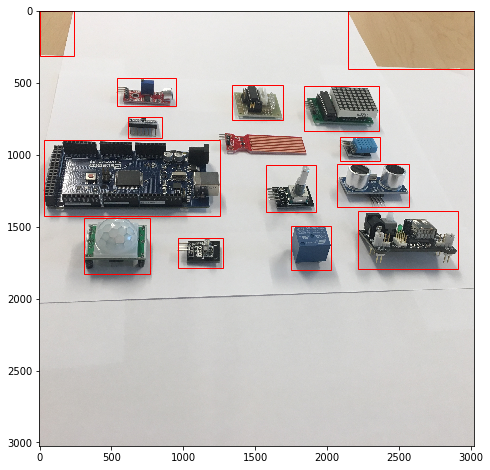

In [10]:
draw_image(image, filtered_blocks)

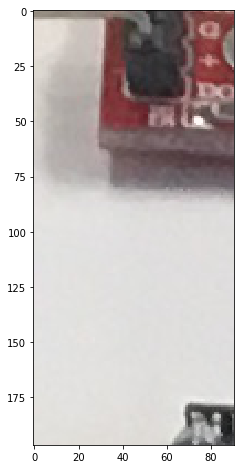

In [11]:
#(556, 569, 91, 197)
submatrix = image[569:569+197,556:556+91]
draw_image(submatrix, [])

In [12]:
from skimage import transform
if submatrix.shape[2] == 4:
    submatrix = submatrix[:, :, :3]
submatrix = transform.resize(submatrix, (200, 200))
draw_image(submatrix, [])


C:\Users\bunny\AppData\Local\Programs\Python\Python36\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


In [13]:
w = 200
h = 200
c = 3

sub_images = []
for block in filtered_blocks:
    _x = block[0]
    _y = block[1]
    _w = block[2]
    _h = block[3]
    sub_image = image[_y:_y + _h, _x:_x + _w]
    if sub_image.shape[2] == 4:
        sub_image = sub_image[:, :, :3]
    sub_image = transform.resize(sub_image, (w, h))
    sub_images.append(sub_image)

C:\Users\bunny\AppData\Local\Programs\Python\Python36\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


In [14]:
from tensorflow import keras
from tensorflow.python.keras import regularizers
from tensorflow.python.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten
from tensorflow.python.keras.models import Sequential


input_shape = (w, h, c)
learning_rate = 0.0001
regularization_rate = 0.0001
category_count = 13 + 1


array([11,  8,  9,  0,  4, 10,  6,  7,  1, 12,  3,  0,  5,  2],
      dtype=int64)

In [15]:
from keras.models import load_model

train_path = r'C:\Users\bunny\Desktop\mega_2560_cat\TRAIN/'
model = load_model(train_path + '/model.h5')

array([11,  8,  9,  0,  4, 10,  6,  7,  1, 12,  3,  0,  5,  2],
      dtype=int64)

In [16]:
import tensorflow as tf
from tensorflow.python.keras.backend import set_session

config = tf.ConfigProto()
config.gpu_options.allow_growth = True
set_session(tf.Session(config=config))


array([11,  8,  9,  0,  4, 10,  6,  7,  1, 12,  3,  0,  5,  2],
      dtype=int64)

In [17]:
import numpy as np
cat = model.predict_classes(np.asarray(sub_images, np.float32))
cat


array([11,  8,  9,  0,  4, 10,  6,  7,  1, 12,  3,  0,  5,  2],
      dtype=int64)

In [18]:
cat_list = [
    "blank",
    "gy-521_module",
    "ir_receiver_module",
    "max7219_module",
    "mega2560_controller_board",
    "pir_motion_sensor_HC-SR501",
    "power_supply_module",
    "relay_5v",
    "rotary_encoder_module",
    "sound_sensor_module",
    "stepper_motor_driver_board_uln2003",
    "temperature_and_humidity_module_DHT11",
    "ultrasonic_sensor",
    "water_level_detection_sensor_module",
]


In [19]:
%matplotlib inline
def draw_name_on_image(img, block_candidates):
    # draw rectangles on the original image
    fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(20, 20))
    plt.imshow(img)
    for x, y, w, h in block_candidates:
        rect = mpatches.Rectangle(
            (x, y), w, h, fill=False, edgecolor='red', linewidth=1)
        ax.add_patch(rect)
    for block in block_candidates:
        x = block[0]
        y = block[1]
        index = block_candidates.index(block)
        plt.text(x,y,cat_list[cat[index]], color = 'green', fontsize = 16)

    plt.show()
    fig.savefig("test.png")


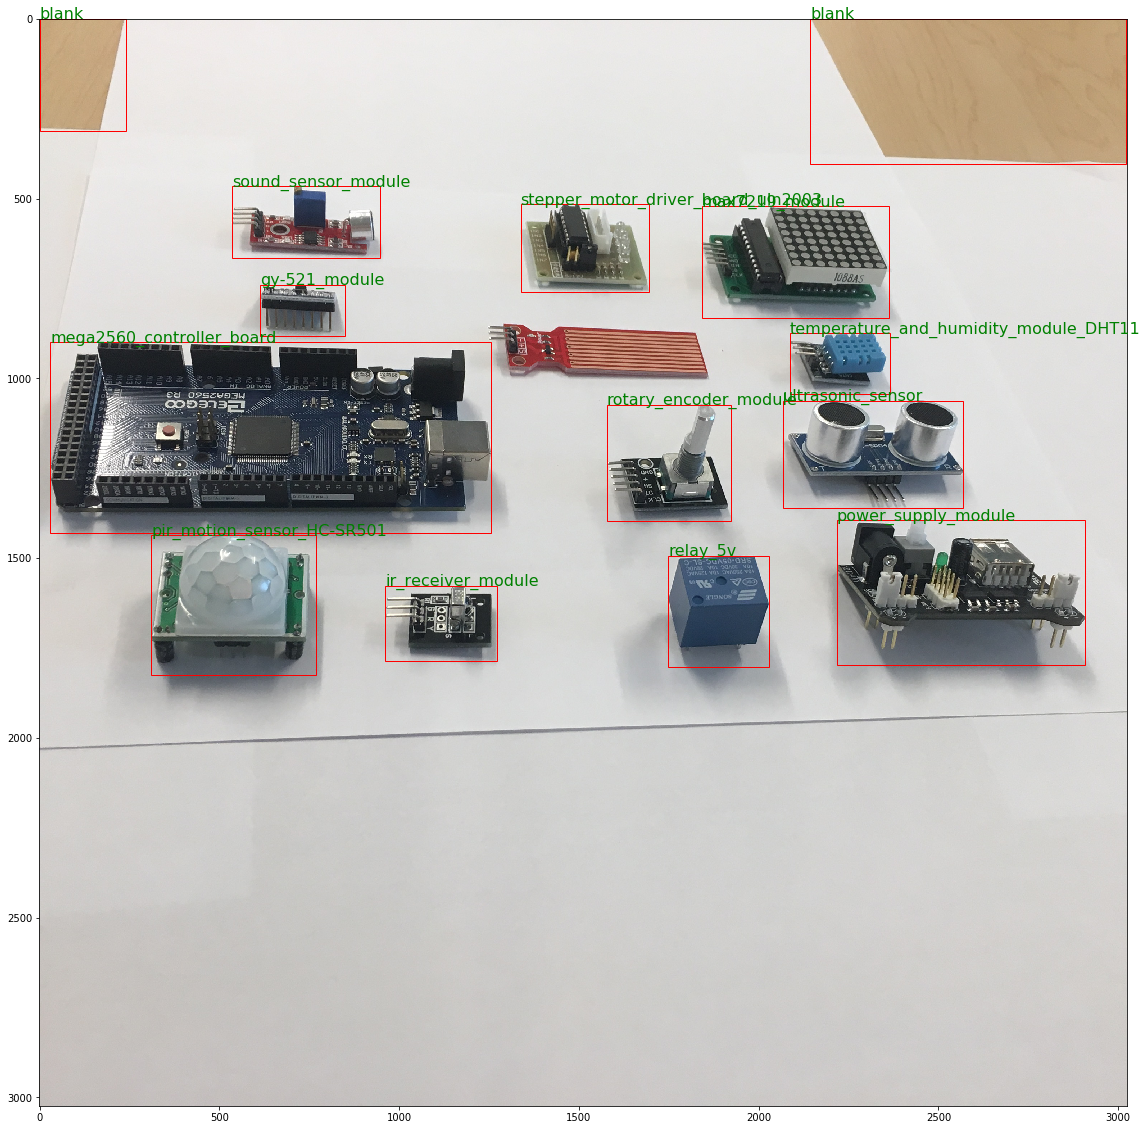

In [20]:
draw_name_on_image(image, filtered_blocks)